# Cleaned notebook for simple CAM analysis and calculation of properties
This is a modified version of the AT_CAM notebook. -- Carter 04/13/21


In [1]:
import re
import numpy as np
import pandas as pd
import os
from os import walk
import math

import cv2 as cv
import networkx as nx

import matplotlib.pyplot as plt
#from Shapes import shapes
#from Lines import lines

In [2]:
from ipywidgets import interact

### Pulling in Data

In [3]:
file_path = '/home/carterrhea/Dropbox/APLS-CAM-Proposal/DataFinal/Clean/' #path to data on local computer

In [4]:
#Function to get unique elements from a list
def list_unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
            
    return unique_list

In [5]:
def make_id_list(my_file_path):

    #pull all filenames in your data directory
    _, _, filenames = next(walk(my_file_path))

    #grab only the id from the filenames to feed to the function
    id_list = []
    for filename in filenames:
        filename_split = filename.rsplit('_', 1)
        id_list.append(filename_split[0])
    
    unique_id = list_unique(id_list) #drop duplicate ids, since they are the same for _blocks & _links
        
    
    
    return unique_id

In [6]:
#Get an id_list from your specific file path
my_id_list = make_id_list(file_path)

In [7]:
#Look at total number of cams
len(my_id_list)

159

### Looking at a single CAM

In [8]:
cam_id = my_id_list[2] #grab a single id to just look through code

blocks = pd.read_csv(f'{file_path}/{cam_id}_blocks.csv')
links = pd.read_csv(f'{file_path}/{cam_id}_links.csv')

display(blocks.head())
display(links.head())

,id,title,x_pos,y_pos,width,height,shape,creator,num,comment,timestamp,modifiable,CAM
0,13564,Carbon Tax,557.0,34.0,123.312,92.0,neutral,712,1.0,NaN,NaN,1,821
1,13572,Higher costs,713.0,189.0,160.000,120.0,negative strong,712,2.0,NaN,NaN,1,821
2,13579,Better for the environment,298.0,188.0,160.000,120.0,positive strong,712,3.0,NaN,NaN,1,821
3,13778,Better future for my kids,131.0,402.0,160.000,120.0,positive strong,712,4.0,NaN,NaN,1,821
4,13794,Harder to afford day to day life,618.0,437.0,160.000,120.0,negative,712,8.0,NaN,NaN,1,821


,id,starting_block,ending_block,line_style,creator,num,arrow_type,timestamp,CAM
0,7748,13564,13579,Solid-Weak,712,0,none,17:54:38,821
1,7751,13564,13572,Dashed-Weak,712,0,none,17:54:49,821
2,7971,13579,13778,Solid-Weak,712,0,none,18:08:13,821
3,7984,13572,13794,Dashed-Weak,712,0,none,18:09:16,821


## Create A Graph Using Networkx

### Create a function to build most basic graph

In [9]:
def graph_from_df(node_df, edge_df):
    # Get nodes
    nodes = node_df['id'].to_list()
    
    # Get edges
    edge_start = edge_df['starting_block'].to_list()
    edge_end = edge_df['ending_block'].to_list()
    edges = tuple(zip(edge_start, edge_end))
    
    # Create Graph
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

In [10]:
G = graph_from_df(blocks,links)

### Create a function to add attributes 

In [11]:
def add_node_attributes(graph_name, node_df, attr_name): #attr_column_name must be in quotes
    
    blocks_dict = node_df[['id', attr_name]].set_index('id').to_dict()[attr_name]
    
    nx.set_node_attributes(graph_name, blocks_dict, attr_name)
    

In [12]:
def add_link_attributes(graph_name, edge_df, attr_name):
    attr_full_dict = {}
    
    edge_df['unique_link']= list(zip(edge_df['starting_block'], edge_df['ending_block']))
        
    for idx, row in edge_df.iterrows():
        
        attr_dict = {attr_name: row[attr_name]}
        
        attr_full_dict.update({row['unique_link']:attr_dict})
    
    nx.set_edge_attributes(G, attr_full_dict)
    
    
    

### Make all the Graphs
#### Store all graphs with attributes in a list

In [90]:
graph_list = []
working_id = []
no_data = []
missing_cam = []

for i in my_id_list:
    
    
    try:
        blocks_df = pd.read_csv(f'{file_path}/{i}_blocks.csv')

        links_df = pd.read_csv(f'{file_path}/{i}_links.csv')
        
        if len(links_df)>0:

            G = graph_from_df(blocks_df, links_df)

            add_node_attributes(G,blocks_df,'title')

            add_node_attributes(G,blocks_df,'shape')

            add_link_attributes(G, links_df, 'line_style')

            graph_list.append(G)
            
            working_id.append(i)

        
        else:
            no_data.append(i)
    
    except:
        
        missing_cam.append(i)
        print(f'CAM {i} does not exist')

print('Summary Info:')
print(f'number of missing cams: {len(missing_cam)}')
print(f'number of cams with no links: {len(no_data)}')
print(f'number of complete cams: {len(working_id)}')


CAM 575ec4be3fc3ac000611df4c__771 does not exist
Summary Info:
number of missing cams: 1
number of cams with no links: 32
number of complete cams: 126


#### Look at one of the graphs stored in your graph list

[(13702, 13720, {'line_style': 'Solid-Weak'}), (13702, 13963, {'line_style': 'Solid-Weak'}), (13702, 13714, {'line_style': 'Solid-Weak'}), (13702, 13763, {'line_style': 'Solid-Weak'})]
-------------------------
[(13702, {'title': 'Carbon Tax', 'shape': 'neutral'}), (13714, {'title': 'Leads to a better environment', 'shape': 'ambivalent'}), (13720, {'title': 'Corporate tax evasion', 'shape': 'negative'}), (13763, {'title': 'Encourages use of environmentally-friendly alternatives', 'shape': 'positive'}), (13963, {'title': 'Hurts low income consumers', 'shape': 'negative'})]


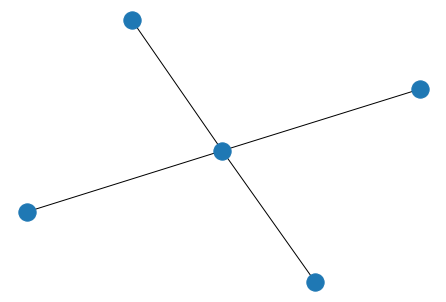

In [91]:
my_graph = graph_list[1]

nx.draw(my_graph)
print(my_graph.edges(data = True))
print('-------------------------')
print(my_graph.nodes(data = True))


In [27]:
emo_dep2(my_graph, 13702)

{13720: {'line_style': 'Solid-Weak'}, 13963: {'line_style': 'Solid-Weak'}, 13714: {'line_style': 'Solid-Weak'}, 13763: {'line_style': 'Solid-Weak'}}
negative
negative
ambivalent
positive


-1.0

## Diversity Measure
Carter 02/19/21 

This comes from pg 5 of the following paper: https://arxiv.org/pdf/0901.1380.pdf



In [15]:
# Create distance matrix
D = np.zeros((7,7))  # We have seven node types hence 7 (note that we consider ambivalent as the same as neutral in this calculation)
dist_ = np.arange(7)
for i in range(7):
    D[i,i:] = dist_
    D[i:,i] = dist_
    dist_ = dist_[:-1]

def calculate_diversity(D, probs):
    """
    Calculate Stirling Diversity measure with alpha = beta = 1
    Args:
        param: D - Distance Matrix
        param: probs - list of probabilities in order of Strong Negative, Negative, Weak Negative, Neutral, Weak Positive, Positive, Strong Positive
    """
    S = 0
    for i in range(7):
        for j in range(7):
            S += D[i, j]*probs[i]*probs[j]
    return S

## Emotional Dependence Calculation


This measure, emotional dependence, is meant to capture the essense of emotion coherence according to Paul Thaggard. This measure will be calculated on the central nodes of a graph. We define the central nodes as the three nodes with the highest centrality score. 

We calculate the emotional dependance in two manners:

 1 - Treat dashed lines as solid lines. We assign +1 to the emotional dependence score for each connected node (dashed or solid) with the same valence. We do not include valence strengths (i.e. Strong Positive -> Positive). Assign -1 to the emotional dependence score for each connected node with a difference valence (i.e. if the central node is positive and the connected node is either negative, neutral, or ambivalent we will subtract 1)
 
 2 - Treat dashed lines separately. We assign +1 to the emotional dependence score for each node with the same valence connected by a dashed line. If the nodes are connected by a solid line and are of different valences, we also assign 1 to the emotional dependence score. Otherwise we subtract 1 from the score. i.e. if a positive central node is connected to a negative node via a dashed line, we add 1 to the emotional dependence score. 
 
In order to normalize our results, we divide the scores by the number of connections to the central node.

In [65]:
def emo_dep1(graph, central):
    '''
    Calculate emotional dependence as described above in scenario 1.
    '''
    emo_dep_score = 0
    # Get connected nodes
    connections = graph[central]
    # Valence of central node
    cen_shape = graph.nodes[central]['shape']
    #print(cen_shape)
    for connect in connections:
        # Valence of connection
        connect_shape = graph.nodes[connect]['shape'].split(' ')[0]  # Take only valence type 
        #print(connect_shape)
        if cen_shape == connect_shape:
            emo_dep_score += 1
        else:
            emo_dep_score -= 1
    if emo_dep_score != 0:
        final_score = emo_dep_score/len(connections)
    else:
        final_score = 0
    return final_score

def emo_dep2(graph, central):
    '''
    Calculate emotional dependence as described above in scenario 1.
    '''
    emo_dep_score = 0
    # Get connected nodes
    connections = graph[central]
    # Valence of central node
    cen_shape = graph.nodes[central]['shape']
    #print(connections)
    for connect in connections:
        # Valence of connection
        connect_style = graph.get_edge_data(central,connect)['line_style'].split('-')[0].lower()  # Only want solid or dashed in lowercase
        # Valence of connected node
        connect_shape = graph.nodes[connect]['shape'].split(' ')[0]  # Take only valence type 
        #print(connect_shape)
        if cen_shape == connect_shape:  # If the nodes have the same valence
            if connect_style == 'solid':  # If they are connected by a solid line
                emo_dep_score += 1
            else:  # If they are connected by a dashed line
                emo_dep_score -= 1
        else:  # If nodes have different valences
            if connect_style == 'solid':  # If they are connected by a solid line
                emo_dep_score -= 1
            else:  # If they are connected by a dashed line
                emo_dep_score += 1
    if emo_dep_score != 0:
        final_score = emo_dep_score/len(connections)
    else:
        final_score = 0
    return final_score

In [132]:
df_blocks = pd.read_csv(file_path+'/5a4e8f4930adf7000106fd5e_928_blocks.csv')
df_links = pd.read_csv(file_path+'/5a4e8f4930adf7000106fd5e_928_links.csv')
positive_list = ['positive strong', 'positive','positive weak']
negative_list = ['negative strong','negative','negative weak']
neutral_list = ['neutral','ambivalent']

solid_list = ['Solid', 'Solid-Strong', 'Solid-Weak']  # Solid link types
dashed_list = ['Dashed', 'Dashed-Strong', 'Dashed-Weak']  # Dashed link types
block_neg = 0
block_pos = 0
block_neut = 0

link_solid = 0
link_dashed = 0
dictionary_list = []
#Get proportion of positive and negative nodes
for i in range(len(df_blocks)):
    if df_blocks['shape'][i] in negative_list:
        block_neg = block_neg + 1
    elif df_blocks['shape'][i] in positive_list:
        block_pos = block_pos + 1
    else:
        block_neut = block_neut + 1

# Get proportion of solid and dashed lines
for i in range(len(df_links)):
    if df_links['line_style'][i] in solid_list:
        link_solid += 1
    else:
        link_dashed += 1

# Get probabilities of each type of node -- used for diversity calculation
neg_strong = df_blocks[df_blocks['shape']=='negative strong'].count().id
neg = df_blocks[df_blocks['shape']=='negative'].count().id
neg_weak = df_blocks[df_blocks['shape']=='negative weak'].count().id
neutral = df_blocks[(df_blocks['shape']=='neutral') & (df_blocks['shape']=='ambivalent')].count().id
pos_weak = df_blocks[df_blocks['shape']=='positive weak'].count().id
pos = df_blocks[df_blocks['shape']=='positive'].count().id
pos_strong = df_blocks[df_blocks['shape']=='positive strong'].count().id
probs = [neg_strong, neg, neg_weak, neutral, pos_weak, pos, pos_strong]
div_ = calculate_diversity(D, probs)
#print(div_)

# Get nodes
nodes = df_blocks['id'].to_list()
# Get edges
edge_start = df_links['starting_block'].to_list()
edge_end = df_links['ending_block'].to_list()
edges = tuple(zip(edge_start, edge_end))

# Create Graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
Gd = graph_from_df(df_blocks, df_links)
add_node_attributes(Gd,df_blocks,'title')

add_node_attributes(Gd,df_blocks,'shape')
#print(df_links['line_style'])
add_link_attributes(Gd,df_links,'line_style')
styles = []
for edge_ in Gd.edges:
    print(edge_)
    style = df_links.loc[(df_links['starting_block']==edge_[0])&(df_links['ending_block']==edge_[1])]['line_style']
    if len(style.values) > 0:
        style = style.values[0]
    else:
        style = ''
    attrs = {edge_: {"line_style": style}}
    nx.set_edge_attributes(Gd, attrs)
#nx.set_edge_attributes(Gd, 'line_style', styles)
#print(Gd.edges(data = True))

degree_centrality = nx.degree_centrality(G)
max_centrality_ind = np.argmax(list(degree_centrality.values()))
central_node = list(degree_centrality.keys())[max_centrality_ind]
emo_dep2(Gd,central_node)
Gd[14254]

(14254, 14279)
(14268, 14298)
(14268, 14287)
(14268, 14319)
(14287, 14293)
(14293, 14300)
(14285, 14307)
(14279, 14307)
(14279, 14304)
(14279, 14319)
(14300, 14298)
(14319, 14327)


AtlasView({14279: {'line_style': 'Solid-Strong'}})

## Functions to get all the network measures

In [137]:
def calc_CAM_GLI(id_list):
    positive_list = ['positive strong', 'positive','positive weak']
    negative_list = ['negative strong','negative','negative weak']
    neutral_list = ['neutral','ambivalent']
    
    solid_list = ['Solid', 'Solid-Strong', 'Solid-Weak']  # Solid link types
    dashed_list = ['Dashed', 'Dashed-Strong', 'Dashed-Weak']  # Dashed link types
    
    dictionary_list = []
    
    for cam_id in id_list:
        block_neg = 0
        block_pos = 0
        block_neut = 0
        
        link_solid = 0
        link_dashed = 0
        
        try:
            df_blocks = pd.read_csv(f'{file_path}/{cam_id}_blocks.csv')
            df_links = pd.read_csv(f'{file_path}/{cam_id}_links.csv')

            #Get proportion of positive and negative nodes
            for i in range(len(df_blocks)):
                if df_blocks['shape'][i] in negative_list:
                    block_neg = block_neg + 1
                elif df_blocks['shape'][i] in positive_list:
                    block_pos = block_pos + 1
                else:
                    block_neut = block_neut + 1

            # Get proportion of solid and dashed lines
            for i in range(len(df_links)):
                if df_links['line_style'][i] in solid_list:
                    link_solid += 1
                else:
                    link_dashed += 1

            # Get probabilities of each type of node -- used for diversity calculation
            neg_strong = df_blocks[df_blocks['shape']=='negative strong'].count().id
            neg = df_blocks[df_blocks['shape']=='negative'].count().id
            neg_weak = df_blocks[df_blocks['shape']=='negative weak'].count().id
            neutral = df_blocks[(df_blocks['shape']=='neutral') & (df_blocks['shape']=='ambivalent')].count().id
            pos_weak = df_blocks[df_blocks['shape']=='positive weak'].count().id
            pos = df_blocks[df_blocks['shape']=='positive'].count().id
            pos_strong = df_blocks[df_blocks['shape']=='positive strong'].count().id
            probs = [neg_strong, neg, neg_weak, neutral, pos_weak, pos, pos_strong]
            div_ = calculate_diversity(D, probs)
            #print(div_)

            # Get nodes
            nodes = df_blocks['id'].to_list()

            # Get edges
            edge_start = df_links['starting_block'].to_list()
            edge_end = df_links['ending_block'].to_list()
            edges = tuple(zip(edge_start, edge_end))

            # Create Graph
            G = nx.Graph()
            G.add_nodes_from(nodes)
            G.add_edges_from(edges)
            
            # Create Graph for emotional dependence calculations
            Gd = graph_from_df(df_blocks, df_links)
            add_node_attributes(Gd, df_blocks, 'title')
            add_node_attributes(Gd, df_blocks, 'shape')
            # Add edge line_style attribute
            for edge_ in Gd.edges:
                style = df_links.loc[(df_links['starting_block']==edge_[0])&(df_links['ending_block']==edge_[1])]['line_style']
                if len(style.values) > 0:
                    style = style.values[0]
                else:
                    style = ''
                attrs = {edge_: {"line_style": style}}
                nx.set_edge_attributes(Gd, attrs)

            # Calculate Density
            density = np.round(nx.density(G), 3)
            node_count = G.number_of_nodes()
            edge_count = G.size()

            # Calculate longest path
            try:
                components = nx.connected_components(G)
                largest_component = max(components, key=len)
                subgraph = G.subgraph(largest_component)
                diameter = nx.diameter(subgraph)
            except:
                diameter = 0
            # Calculate transitivity
            triadic_closure = np.round(nx.transitivity(G), 3)

            # Calculate max degree
            try:
                degree_centrality = nx.degree_centrality(G)
                max_centrality_ind = np.argmax(list(degree_centrality.values()))
                central_node = list(degree_centrality.keys())[max_centrality_ind]
                central_node_title = df_blocks[df_blocks['id'] == central_node]['title'].values[0]
                central_node_valence = df_blocks[df_blocks['id'] == central_node]['shape'].values[0]
                central_node_val = np.round(list(degree_centrality.values())[max_centrality_ind], 3)
                # Calculate emotional dependence
                #print(emo_dep1(G, int(central_node)))
                emo_dep1_score = emo_dep1(Gd, central_node)
                emo_dep2_score = emo_dep2(Gd, central_node)
            except:
                central_node = 0
                central_node_title = ''
                central_node_val = 0
                #emo_dep1_score = 0
                #emo_dep2_score = 0
                #emo_dep1_score = emo_dep2(G, central_node)
           
            # Eigenvector Centrality
            try:
                eigenvector_centrality = nx.eigenvector_centrality(G)
                max_centrality_ind = np.argmax(list(eigenvector_centrality.values()))
                central_node_val_eig = np.round(list(eigenvector_centrality.values())[max_centrality_ind], 3)
            except:
                central_node_val_eig = 0

            # Betweeness Centrality
            try:
                betweenness_centrality = nx.betweenness_centrality(G)
                max_centrality_ind = np.argmax(list(betweenness_centrality.values()))
                central_node_val_bet = np.round(list(betweenness_centrality.values())[max_centrality_ind], 3)
            except:
                central_node_val_bet = 0
            
            # Assortativity
            try:
                assortativity = nx.degree_assortativity_coefficient(G)
            except:
                assortativity = 0
            
        
                
            
            # Make the dictionary
                #add in ratio of node val
                #add number of type of node
            density_dict = {
                'cam_id': cam_id,
                'node_count': node_count,
                'positive_nodes':block_pos,
                'negative_nodes':block_neg,
                'neutral_nodes':block_neut,
                'link_solid': link_solid,
                'link_dashed': link_dashed,
                'edge_count': edge_count,
                'density': density,
                'diameter': diameter,
                'triadic_closure': triadic_closure,
                'central_node': central_node,
                'central_node_title': central_node_title,
                'central_node_valence': central_node_valence,
                'central_node_val': central_node_val,
                'central_node_val_eig': central_node_val_eig,
                'central_node_val_bet': central_node_val_bet,
                'assortativity': assortativity,
                #'closeness': closeness,
                'diversity': div_,
                'emo_dep1': emo_dep1_score,
                'emo_dep2': emo_dep2_score
            }

            dictionary_list.append(density_dict)
            
        except:
            print(f'No file found for {cam_id}')
        
    cam_density_df = pd.DataFrame(dictionary_list)
            
    return cam_density_df

In [138]:
cam_GLI_df = calc_CAM_GLI(my_id_list)
display(cam_GLI_df)

/home/carterrhea/anaconda3/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:287: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)
/home/carterrhea/anaconda3/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:287: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)
/home/carterrhea/anaconda3/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:287: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


No file found for 575ec4be3fc3ac000611df4c__771


/home/carterrhea/anaconda3/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:287: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)
/home/carterrhea/anaconda3/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:287: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)
/home/carterrhea/anaconda3/lib/python3.8/site-packages/networkx/algorithms/assortativity/correlation.py:287: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


,cam_id,node_count,positive_nodes,negative_nodes,neutral_nodes,link_solid,link_dashed,edge_count,density,diameter,...,central_node,central_node_title,central_node_valence,central_node_val,central_node_val_eig,central_node_val_bet,assortativity,diversity,emo_dep1,emo_dep2
0,5f86545822cf5c1a8f21ad3d_929,13,6,5,2,18,0,18,0.231,3,...,14203,Carbon Tax,neutral,0.750,0.569,0.750,-0.490446,312.0,-0.777778,-0.777778
1,5a5e51de76d1c60001ab65b9_840,5,1,2,2,4,0,4,0.400,2,...,13702,Carbon Tax,neutral,1.000,0.707,1.000,-1.000000,16.0,-1.000000,-1.000000
2,5f1b14b5f904e60fba8b4e70_821,5,2,2,1,2,2,4,0.400,4,...,13564,Carbon Tax,neutral,0.500,0.577,0.667,-0.333333,46.0,-1.000000,0.000000
3,5bc0cacb228a7600013cf77e_857,6,3,2,1,3,2,5,0.333,2,...,13781,Carbon tax,neutral,1.000,0.707,1.000,-1.000000,48.0,-1.000000,-0.200000
4,5f8848aec378732c550c555a_998,5,4,0,1,7,0,7,0.700,2,...,14731,Carbon Tax Pricing,neutral,1.000,0.559,0.333,-0.500000,12.0,-1.000000,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,5e94ae0942eb133064297a25_891,2,0,0,2,1,0,1,1.000,1,...,14035,CarbonTax,ambivalent,1.000,0.707,0.000,NaN,0.0,-1.000000,-1.000000
154,5f4a274f21ec8a5971fbb33f_894,9,3,3,3,11,1,12,0.333,4,...,14009,Large corporations,neutral,0.625,0.544,0.327,-0.407821,66.0,-0.200000,-0.200000
155,5eed1ee2cb93ea12dfc13405_899,9,3,5,1,8,6,14,0.389,2,...,14046,CarbonTax,neutral,1.000,0.588,0.732,-0.550256,138.0,-1.000000,-0.250000
156,5fc5479e0c13f804b402c760_811,12,5,4,3,11,5,16,0.242,4,...,13529,Carbon Tax,neutral,0.455,0.477,0.545,-0.148148,164.0,-0.600000,-0.600000


In [139]:
#get a df of the number of cams per node count
node_count_df = pd.DataFrame(cam_GLI_df.groupby('node_count',as_index=False).count()[['node_count','edge_count']]).rename(columns={'edge_count':'cam_count'})
node_count_df.head(5)

,node_count,cam_count
0,0,24
1,1,4
2,2,2
3,3,5
4,4,4


#### Look at distribution of node count

Text(0.5, 1.0, 'Distribution of Node Count')

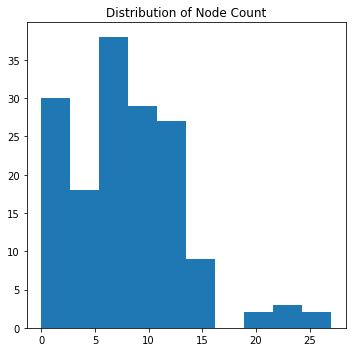

In [140]:
fig, axs = plt.subplots(figsize=(5,5),sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs.hist(cam_GLI_df['node_count'])
axs.set_title('Distribution of Node Count')


## Add Survey Info to CAM data

In [142]:
file_path_survey = '/home/carterrhea/Dropbox/APLS-CAM-Proposal/DataFinal/survey_cam_merge.final.csv'
survey_df = pd.read_csv(file_path_survey)
#survey_df.head()

In [143]:
#drop NAs
survey_df_dropna = survey_df.dropna(subset=['Prolific1','Gender'])

In [144]:
#Get the cam dataframe ready to merge with the survey data
cam_GLI_full = cam_GLI_df.copy()
Prolific1_list=cam_GLI_full['cam_id'].str.split('_').str[0]
cam_GLI_full.insert(loc=0, column='Prolific1', value=Prolific1_list)
cam_GLI_full = cam_GLI_full.drop(cam_GLI_full.columns[1], axis=1)

In [145]:
print(f'The length of cam_df: {len(cam_GLI_full)}')
print(f'The length of survey_df: {len(survey_df_dropna)}')

The length of cam_df: 158
The length of survey_df: 123


In [150]:
survey_cam_merge = pd.merge(cam_GLI_full, survey_df_dropna, how = 'inner', on = 'Prolific1')
survey_cam_merge.to_csv('~/Downloads/survey_cam_merge.csv')

In [151]:
print(f'The length of merged data: {len(survey_cam_merge)}')

The length of merged data: 149


In [154]:
survey_cam_merge = survey_cam_merge.drop_duplicates(subset=['Prolific1'], keep='last')
print(f'The length of merged data: {len(survey_cam_merge)}')
survey_cam_merge.to_csv('~/Downloads/survey_cam_merge_final.csv')

The length of merged data: 111
